In [1]:
"""Module with examples of S3 dataset + EDA."""
import tempfile

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pydub import AudioSegment
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

HOST = "storage.yandexcloud.net"
SCHEMA = "https"
AWS_ACCESS_KEY_ID = ...
AWS_SECRET_ACCESS_KEY = ...
BUCKET_NAME = ...

s3_client = boto3.client(
        "s3",
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        endpoint_url=f"{SCHEMA}://{HOST}",
)

* Сканируем датасет из S3

In [1]:
from playlist_selection.tracks import S3Dataset  # noqa: E402

s3_dataset = S3Dataset(s3_client=s3_client, bucket_name=BUCKET_NAME, prefix="tracks")
s3_dataset.scan()


* Получаем Pandas Dataframe с данными

In [5]:
pd.set_option("display.max_columns", 200)
df = s3_dataset.to_pandas()
df.shape

(29592, 45)

* Пример объектов

In [6]:
pd.set_option("display.max_rows", 200)
df.head()

,key,genre,audio_path,album_name,album_id,album_release_date,artist_name,artist_id,track_id,track_name,genres,duration_ms,explicit,popularity,is_local,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,time_signature,bars_number,bars_mean_duration,beats_number,beats_mean_duration,tatums_number,tatums_mean_duration,sections_number,sections_mean_duration,sections_mean_tempo,sections_mean_key,sections_mean_mode,sections_mean_time_signature,segments_number,segments_mean_duration,segments_mean_pitch,segments_max_pitch,segments_min_pitch,segments_mean_timbre,segments_max_timbre,segments_min_timbre
0,61_HighwayCorey_Harris,acoustic,tracks/acoustic/61_HighwayCorey_Harris/audio.mp3,Between Midnight And Day,6fuRNpnOE7QgyT1IcdvpED,1995-10-31,[Corey Harris],[1TQtbRQbaXw5CeN3mC0DJH],3zGcBpopIzVBqqHRoRTCR2,61 Highway,"[acoustic blues, country blues, modern blues]",288520.0,False,5.0,False,0.637,0.0229,-22.846,1.0,0.0440,0.907,0.000145,0.226,80.923,4.0,71.0,3.006266,345.0,0.750690,690.0,0.375345,7.0,31.672076,80.341167,7.333333,1.0,4.0,780.0,0.318523,0.255563,1.0,0.039800,-5.691454,66.999615,-89.520079
1,A_Rat_In_My_DreamBlackbird_Raum,acoustic,tracks/acoustic/A_Rat_In_My_DreamBlackbird_Rau...,Swidden,2FQOhgfjT2SY5ftlJPo2J0,2010-10-05,[Blackbird Raum],[2OX8UjaYkhqkZN9n7kbQLx],6f3gH7xUWu2maSO8pMWza0,A Rat In My Dream,"[acoustic punk, folk punk, gypsy punk]",68293.0,False,24.0,False,0.419,0.2750,-7.686,1.0,0.0374,0.768,0.000000,0.175,124.643,3.0,27.0,1.464499,65.0,0.480729,130.0,0.240365,3.0,17.186097,123.898000,1.000000,1.0,2.0,143.0,0.350626,0.296862,1.0,0.060042,10.736050,63.383944,-47.035636
2,A_Whole_New_WorldDisney_Peaceful_Guitar,acoustic,tracks/acoustic/A_Whole_New_WorldDisney_Peacef...,Disney Guitar: Breathe,1BkRLMg1PwegXipKVRXeiI,2020-08-07,"[Disney Peaceful Guitar, Disney]","[3oqzxUlHhjJ7auI4dVujKX, 3xvaSlT4xsyk6lY1ESOspO]",4PMQ9IidXtvDdhmlH4IBPD,A Whole New World,[acoustic guitar cover],167709.0,False,56.0,False,0.847,0.1460,-12.368,1.0,0.0488,0.941,0.932000,0.281,99.994,4.0,56.0,2.335994,255.0,0.599939,510.0,0.299969,5.0,23.336862,100.083000,2.000000,1.0,4.0,289.0,0.526282,0.207748,1.0,0.020567,-1.118421,50.936284,-87.081986
3,Ab's_SongIron_&_Wine,acoustic,tracks/acoustic/Ab's_SongIron_&_Wine/audio.mp3,Sing Into My Mouth,0jMBAo2pk2cEE0aJ3WseMl,2015-07-17,"[Iron & Wine, Ben Bridwell]","[4M5nCE77Qaxayuhp3fVn4V, 6Vfn70eqp3AgtiZZtQcv4W]",0lovF4eevVqfpVRNYzfmmV,Ab's Song,"[acoustic pop, chamber pop, indie folk, indie ...",79366.0,False,44.0,False,0.651,0.3550,-9.841,1.0,0.0267,0.639,0.000580,0.912,87.189,4.0,15.0,2.754049,97.0,0.688586,194.0,0.344293,3.0,14.934163,87.161333,7.000000,1.0,3.0,211.0,0.342537,0.253138,1.0,0.044284,-0.789037,50.828991,-54.978156
4,Across_the_BorderlineRy_Cooder,acoustic,tracks/acoustic/Across_the_BorderlineRy_Cooder...,Music by Ry Cooder,0gLaTb6BP8pySUWwkiZjdD,1995-01-01,[Ry Cooder],[1CPwHx5lgVxv0rfcp7UXLx],64CFnGFSt0rzznXD2XUGUQ,Across the Borderline,"[acoustic blues, blues, country blues, country...",185040.0,False,35.0,False,0.648,0.2030,-17.901,1.0,0.0342,0.606,0.000628,0.570,94.238,4.0,57.0,2.588814,261.0,0.646766,522.0,0.323383,6.0,21.343130,92.652600,2.000000,1.0,4.0,496.0,0.325967,0.280055,1.0,0.062054,-1.680980,47.055127,-64.809298


* Пример значений для объекта

In [7]:
df.iloc[0].T

key                                                       61_HighwayCorey_Harris
genre                                                                   acoustic
audio_path                      tracks/acoustic/61_HighwayCorey_Harris/audio.mp3
album_name                                              Between Midnight And Day
album_id                                                  6fuRNpnOE7QgyT1IcdvpED
album_release_date                                                    1995-10-31
artist_name                                                       [Corey Harris]
artist_id                                               [1TQtbRQbaXw5CeN3mC0DJH]
track_id                                                  3zGcBpopIzVBqqHRoRTCR2
track_name                                                            61 Highway
genres                             [acoustic blues, country blues, modern blues]
duration_ms                                                             288520.0
explicit                    

* Распределение по жанрам

In [8]:
pd.set_option("display.max_rows", 150)
df.dropna(subset=["track_id"])["genre"].value_counts().to_frame()

,count
genre,
alt-rock,313
tango,313
turkish,312
brazil,312
sertanejo,311
spanish,311
black-metal,311
ambient,310
bluegrass,310


* Недокаченая мета

In [9]:
df.isna().sum()

key                                 0
genre                               0
audio_path                        908
album_name                      15819
album_id                        15819
album_release_date              15819
artist_name                     15819
artist_id                       15819
track_id                        15819
track_name                      15819
genres                          15819
duration_ms                     15819
explicit                        15819
popularity                      15819
is_local                        15819
danceability                    15819
energy                          15819
loudness                        15819
mode                            15819
speechiness                     15819
acousticness                    15819
instrumentalness                15819
valence                         15819
tempo                           15819
time_signature                  15819
bars_number                     15852
bars_mean_du

* Проверка корректности меты

In [10]:
df["real_key"] = (df["track_name"] + df["artist_name"].str[0]).str.replace(" ", "_")
df[(df["key"] != df["real_key"]) & ~df["track_id"].isna()]

,key,genre,audio_path,album_name,album_id,album_release_date,artist_name,artist_id,track_id,track_name,genres,duration_ms,explicit,popularity,is_local,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,time_signature,bars_number,bars_mean_duration,beats_number,beats_mean_duration,tatums_number,tatums_mean_duration,sections_number,sections_mean_duration,sections_mean_tempo,sections_mean_key,sections_mean_mode,sections_mean_time_signature,segments_number,segments_mean_duration,segments_mean_pitch,segments_max_pitch,segments_min_pitch,segments_mean_timbre,segments_max_timbre,segments_min_timbre,real_key


* Отбираем треки, для которых уже готова мета и .mp3

In [12]:

df_filtered = df[~df["audio_path"].isna() & ~df["track_id"].isna()]
print(df_filtered.shape)
df_filtered.to_csv("filtered_data.csv", index=False)

(12865, 46)


* Проверка скаченных треков

In [13]:
def get_mp3_duration(file_path: str) -> float:
    """Return duration of mp3 file."""
    audio = AudioSegment.from_file(file_path)
    duration_seconds = len(audio) / 1000.0
    del audio
    return duration_seconds

def get_file_size(file_path: str) -> float:
    """Return file size in MB."""
    import os
    size_bytes = os.path.getsize(file_path)
    size_megabytes = size_bytes / (1024.0 * 1024.0)
    return size_megabytes

real_durations = []
files_sizes = []
for i, row in tqdm(df_filtered.iterrows()):
    try:
        with tempfile.NamedTemporaryFile() as temp_dir:
            s3_client.download_file(Filename=temp_dir.name, Key=row["audio_path"], Bucket=BUCKET_NAME)
            file_size = get_file_size(temp_dir.name)
            files_sizes.append(file_size)
            if file_size > 10:
                raise RuntimeError(f"BIG FILE SIZE {file_size}.")
            audio_duration = get_mp3_duration(temp_dir.name)
            real_durations.append(audio_duration * 1000)
    except Exception as e:
        print(e)
        real_durations.append(None)
        
df_filtered["real_duration_ms"] = real_durations
df_filtered["file_size_mb"] = files_sizes

0it [00:00, ?it/s]

BIG FILE SIZE 66.18007850646973.
BIG FILE SIZE 14.313915252685547.
BIG FILE SIZE 66.18007850646973.
BIG FILE SIZE 14.0746431350708.
BIG FILE SIZE 20.98988151550293.
BIG FILE SIZE 24.219497680664062.
BIG FILE SIZE 24.219497680664062.
BIG FILE SIZE 58.50309181213379.
BIG FILE SIZE 24.983153343200684.
BIG FILE SIZE 14.859381675720215.
BIG FILE SIZE 11.078108787536621.
BIG FILE SIZE 11.94933032989502.
BIG FILE SIZE 12.288705825805664.
BIG FILE SIZE 19.88094425201416.
BIG FILE SIZE 12.073974609375.
BIG FILE SIZE 21.128610610961914.
BIG FILE SIZE 17.38807964324951.
BIG FILE SIZE 24.806596755981445.
BIG FILE SIZE 16.104473114013672.
BIG FILE SIZE 10.063982963562012.
BIG FILE SIZE 17.905993461608887.
BIG FILE SIZE 18.7460994720459.
BIG FILE SIZE 17.91246223449707.
BIG FILE SIZE 20.108181953430176.
BIG FILE SIZE 15.425995826721191.
BIG FILE SIZE 25.485182762145996.
BIG FILE SIZE 10.015052795410156.
BIG FILE SIZE 17.433133125305176.
BIG FILE SIZE 15.000381469726562.
BIG FILE SIZE 11.311809539794

/tmp/ipykernel_1695/3279828895.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["real_duration_ms"] = real_durations
/tmp/ipykernel_1695/3279828895.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["file_size_mb"] = files_sizes


In [14]:
df_filtered.to_csv("df_with_sizes.csv", index=False)

In [15]:
df_filtered.to_csv("df_with_sizes.csv", index=False)

In [6]:
df_filtered = pd.read_csv("df_with_sizes.csv")
df_filtered.head()

,key,genre,audio_path,album_name,album_id,album_release_date,artist_name,artist_id,track_id,track_name,...,segments_mean_duration,segments_mean_pitch,segments_max_pitch,segments_min_pitch,segments_mean_timbre,segments_max_timbre,segments_min_timbre,real_key,real_duration_ms,file_size_mb
0,61_HighwayCorey_Harris,acoustic,tracks/acoustic/61_HighwayCorey_Harris/audio.mp3,Between Midnight And Day,6fuRNpnOE7QgyT1IcdvpED,1995-10-31,['Corey Harris'],['1TQtbRQbaXw5CeN3mC0DJH'],3zGcBpopIzVBqqHRoRTCR2,61 Highway,...,0.318523,0.255563,1.0,0.039800,-5.691454,66.999615,-89.520079,61_HighwayCorey_Harris,288578.0,1.680138
1,A_Rat_In_My_DreamBlackbird_Raum,acoustic,tracks/acoustic/A_Rat_In_My_DreamBlackbird_Rau...,Swidden,2FQOhgfjT2SY5ftlJPo2J0,2010-10-05,['Blackbird Raum'],['2OX8UjaYkhqkZN9n7kbQLx'],6f3gH7xUWu2maSO8pMWza0,A Rat In My Dream,...,0.350626,0.296862,1.0,0.060042,10.736050,63.383944,-47.035636,A_Rat_In_My_DreamBlackbird_Raum,44722.0,0.261071
2,A_Whole_New_WorldDisney_Peaceful_Guitar,acoustic,tracks/acoustic/A_Whole_New_WorldDisney_Peacef...,Disney Guitar: Breathe,1BkRLMg1PwegXipKVRXeiI,2020-08-07,"['Disney Peaceful Guitar', 'Disney']","['3oqzxUlHhjJ7auI4dVujKX', '3xvaSlT4xsyk6lY1ES...",4PMQ9IidXtvDdhmlH4IBPD,A Whole New World,...,0.526282,0.207748,1.0,0.020567,-1.118421,50.936284,-87.081986,A_Whole_New_WorldDisney_Peaceful_Guitar,173035.0,1.007382
3,Ab's_SongIron_&_Wine,acoustic,tracks/acoustic/Ab's_SongIron_&_Wine/audio.mp3,Sing Into My Mouth,0jMBAo2pk2cEE0aJ3WseMl,2015-07-17,"['Iron & Wine', 'Ben Bridwell']","['4M5nCE77Qaxayuhp3fVn4V', '6Vfn70eqp3AgtiZZtQ...",0lovF4eevVqfpVRNYzfmmV,Ab's Song,...,0.342537,0.253138,1.0,0.044284,-0.789037,50.828991,-54.978156,Ab's_SongIron_&_Wine,79459.0,0.464166
4,Across_the_BorderlineRy_Cooder,acoustic,tracks/acoustic/Across_the_BorderlineRy_Cooder...,Music by Ry Cooder,0gLaTb6BP8pySUWwkiZjdD,1995-01-01,['Ry Cooder'],['1CPwHx5lgVxv0rfcp7UXLx'],64CFnGFSt0rzznXD2XUGUQ,Across the Borderline,...,0.325967,0.280055,1.0,0.062054,-1.680980,47.055127,-64.809298,Across_the_BorderlineRy_Cooder,375188.0,2.159058


* Доля некорректных MP3

In [9]:
print("Количество и доля слишком больших MP3:")
print(df_filtered["real_duration_ms"].isna().sum(), df_filtered["real_duration_ms"].isna().mean())

Количество и доля слишком больших MP3:
136 0.010571317528177224


* Разница продолжительности из меты и фактической продолжительности MP3

In [12]:
plot_data = df_filtered[["duration_ms", "real_duration_ms"]].dropna()
plot_data["diff_sec"] = (plot_data["duration_ms"] / 1_000. - plot_data["real_duration_ms"] / 1_000.)

plot_data["diff_sec"].describe()

count    12729.000000
mean        -9.378633
std         74.836872
min      -1521.505000
25%         -2.033000
50%         -0.088000
75%         -0.055000
max        800.781000
Name: diff_sec, dtype: float64

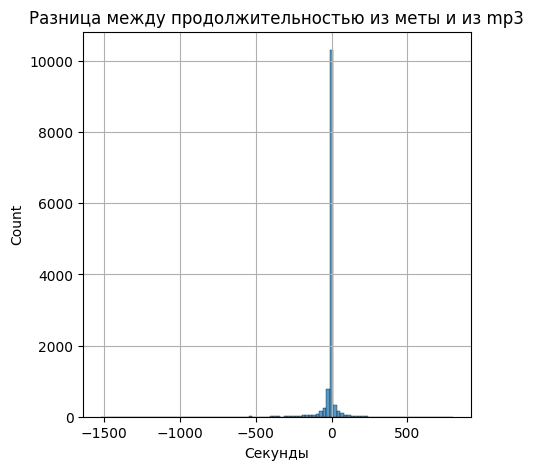

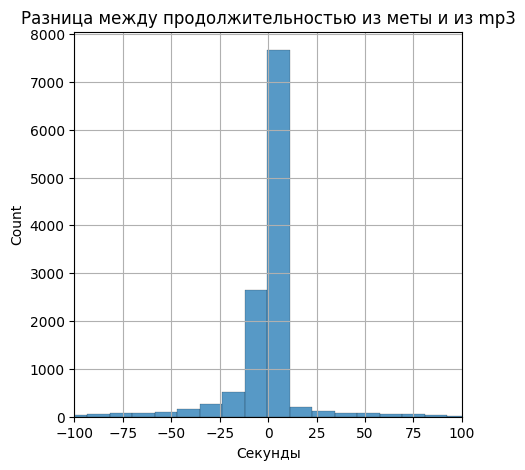

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.histplot(plot_data["diff_sec"], bins=100)
ax.grid(True)
ax.set_title("Разница между продолжительностью из меты и из mp3")
ax.set_xlabel("Секунды")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.histplot(plot_data["diff_sec"], bins=200)
ax.set_xlim(-100, 100)
ax.grid(True)
ax.set_title("Разница между продолжительностью из меты и из mp3")
ax.set_xlabel("Секунды")
plt.show()

Можно сделать __вывод__, что основная часть песен собралась корерректно. 

In [48]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

genres = df_filtered.dropna(subset=["track_id"])["genre"].value_counts()\
        [df_filtered.dropna(subset=["track_id"])["genre"].value_counts() > 294].index
df_genres = df_filtered[df_filtered["genre"].isin(genres)]
numerical_data = df_genres.select_dtypes(include=np.number)
df_filtered.describe(include="all") # .T

,key,genre,audio_path,album_name,album_id,album_release_date,artist_name,artist_id,track_id,track_name,genres,duration_ms,explicit,popularity,is_local,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,time_signature,bars_number,bars_mean_duration,beats_number,beats_mean_duration,tatums_number,tatums_mean_duration,sections_number,sections_mean_duration,sections_mean_tempo,sections_mean_key,sections_mean_mode,sections_mean_time_signature,segments_number,segments_mean_duration,segments_mean_pitch,segments_max_pitch,segments_min_pitch,segments_mean_timbre,segments_max_timbre,segments_min_timbre,real_key,real_duration_ms,file_size_mb
count,12865,12865,12865,12865,12865,12865,12865,12865,12865,12865,12865,1.286500e+04,12865,12865.000000,12865,12865.000000,12865.000000,12865.000000,12865.000000,12865.000000,12865.000000,12865.000000,12865.000000,12865.000000,12865.000000,12837.000000,12837.000000,12837.000000,12822.000000,12837.000000,12822.000000,12856.000000,12856.000000,12063.000000,12010.000000,12689.000000,12830.000000,12865.000000,12858.000000,12858.000000,12858.0,12858.000000,12858.000000,12858.000000,12858.000000,12865,1.272900e+04,12865.000000
unique,12865,101,12865,7496,7667,2222,6004,6007,12865,12586,3262,NaN,2,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12865,NaN,NaN
top,Zen_(Flute_Music)Meditación_Música_Ambiente,alt-rock,tracks/world-music/Zen_(Flute_Music)Meditación...,Greatest Hits,1kCHru7uhxBUdzkm4gzRQc,1990-01-01,['Elvis Presley'],['43ZHCT0cAZBISjO8DG9PnE'],7wdPfEMYsDZhbCRd0t4OvI,Dreaming,['russian romance'],NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zen_(Flute_Music)Meditación_Música_Ambiente,NaN,NaN
freq,1,306,1,31,19,654,65,65,1,5,191,NaN,12155,NaN,12865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.391076e+05,NaN,33.445939,NaN,0.542380,0.597828,-9.778126,0.655499,0.082464,0.365288,0.202702,0.499012,120.946509,3.878663,96.887201,2.042372,325.115525,0.527664,650.226611,0.263848,8.117377,22.895670,121.516933,5.246599,0.679056,3.844648,670.233968,0.289777,0.343600,1.0,0.095591,4.000619,71.195389,-58.192790,NaN,2.464998e+05,2.035508
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.289549e+05,NaN,18.734481,NaN,0.178572,0.264866,5.662879,0.475224,0.128005,0.351192,0.339545,0.269253,30.491073,0.474276,58.341308,0.535369,215.322386,0.135011,430.643000,0.067522,4.313681,7.571260,29.136754,2.731054,0.296543,0.377341,445.772160,0.260872,0.068942,0.0,0.049557,6.646989,17.796827,25.220560,NaN,1.263816e+05,9.389569
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.533000e+03,NaN,0.000000,NaN,0.000000,0.000000,-47.565000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.858695,0.000000,0.244233,0.000000,0.122116,1.000000,5.732020,35.909000,0.000000,0.000000,1.000000,0.000000,0.110705,0.108167,1.0,0.000000,-38.022424,23.189519,-274.288112,NaN,1.546400e+04,0.091918
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.740660e+05,NaN,20.000000,NaN,0.429000,0.408000,-12.049000,0.000000,0.034400,0.020600,0.000000,0.278000,97.879000,4.000000,62.000000,1.677722,191.000000,0.430466,382.000000,0.215233,6.000000,18.771390,98.839810,3.333333,0.500000,3.833333,420.000000,0.241367,0.296501,1.0,0.062981,0.641202,59.496634,-64.479728,NaN,1.777720e+05,1.036342
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.198660e+05,NaN,34.000000,NaN,0.560000,0.631000,-8.437000,1.000000,0.044800,0.258000,0.000368,0.498000,120.033000,4.000000,86.000000,1.946915,289.000000,0.500012,578.000000,0.250008,8.000000,21.846526,120.244667,5.200000,0.750000,4.000000,570.000000,0.277532,0.339882,1.0,0.088253,4.759176,67.847923,-51.067144,NaN,2.244440e+05,1.307191
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

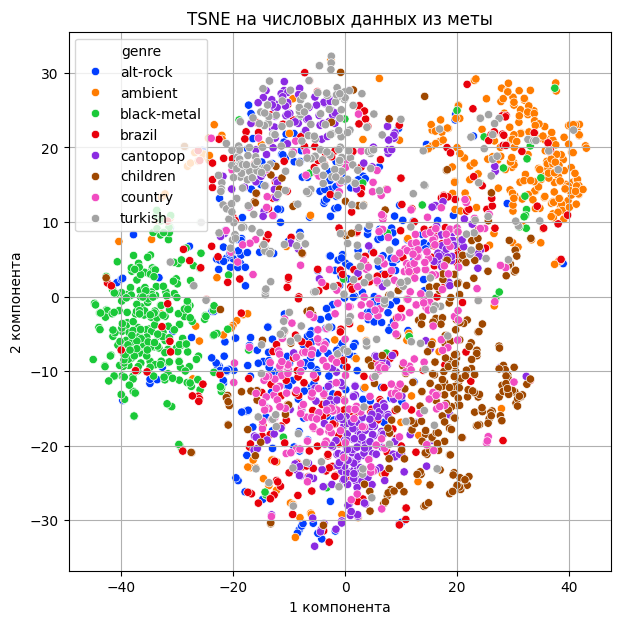

In [53]:
pipe = make_pipeline(SimpleImputer(), StandardScaler(), TSNE(perplexity=50))
transformed_data = pipe.fit_transform(numerical_data)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=transformed_data[:, 0], y=transformed_data[:, 1], hue=df_genres["genre"], palette="bright")
plt.grid(True)
plt.title("TSNE на числовых данных из меты")
plt.xlabel("1 компонента")
plt.ylabel("2 компонента")
plt.show()

In [58]:
sns_plot = sns.pairplot(df_filtered.select_dtypes(include=np.number), corner=False)
plt.gcf().savefig("output.pdf")
plt.close("all")